In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)

import plotly.express as px
import plotly.graph_objects as go
from datetime import datetime
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

sns.set(rc={'figure.figsize':(15,8)})

path_to_catalog=r'C:\Users\kgrzebien\Desktop\python_tasks\reklamacje\\'


In [84]:
def func_read_data(path):
    df=pd.read_csv(path+'.csv',
              encoding='Cp1250',
              sep="|")
    return df
def func_numer_faktury(df):
    df['FAKTURA_NUMER']=df['FAKTURA'].apply(lambda x: x[4:])
    return df
    
def func_str_to_float(s):
    s=s.astype(str)
    s=s.apply(lambda x: x.replace(',','.'))
    s=s.astype(float)
    return s

def func_add_time(df):
    
    df['Z_DNIA']=pd.to_datetime(df['Z_DNIA'], format='%y/%m/%d')
    
    df['year']=df['Z_DNIA'].apply(lambda x: x.year)
    df['month']=df['Z_DNIA'].apply(lambda x: x.month)
    df['day_of_year']=df['Z_DNIA'].apply(lambda x: x.timetuple().tm_yday)
    df['week']=df['Z_DNIA'].apply(lambda x: x.isocalendar()[1])
    df['week_day']=df['Z_DNIA'].apply(lambda x: x.isocalendar()[2])
    df['year_month']=df['year'].astype(str)+'-'+df['month'].astype(str)+'-'+'01'
    df['year_month']=df['year_month'].apply(lambda x: x[:5]+'0'+x[5:] if len(x)==9 else x)
    df['year_month']=pd.to_datetime(df['year_month'], format='%Y-%m-%d')
    df['year_week']=df['year'].astype(str)+'--'+df['week'].astype(str)
    df['year_week']=df['year_week'].apply(lambda x: x[:6]+'0'+x[6:] if len(x)==7 else x)
    df['year_day']=df['year'].astype(str)+'--'+df['day_of_year'].astype(str)
    df['year_day']=df['year_day'].apply(lambda x: x[:6]+'0'+x[6:] if len(x)<9 else x)
    return df

def func_add_kod_fili(df, col_kod):
    df_filia=pd.read_csv('../słowniki/filie.csv',
                         encoding='Cp1250',
                          sep="|")
    df_filia=df_filia.loc[df_filia['IS_DELETED']=='N'][['KOD','ANALIT01','ANALIT02']]
    df_filia.loc[df_filia.loc[df_filia['KOD']=='LI'].index, 'ANALIT01']='LI'
    df_filia.loc[df_filia.loc[df_filia['KOD']=='LI'].index, 'ANALIT02']='LIKWIDACJA'
    df_filia.loc[df_filia.loc[df_filia['KOD']=='00'].index, 'ANALIT01']='00'
    df_filia.loc[df_filia.loc[df_filia['KOD']=='00'].index, 'ANALIT02']='MAGAZYN_00'
    df_filia.loc[df_filia.loc[df_filia['KOD']=='65'].index, 'ANALIT01']='FE'
    df_filia.loc[df_filia.loc[df_filia['KOD']=='65'].index, 'ANALIT02']='FELER'
    df=df.merge(df_filia, how='left', left_on=col_kod, right_on='KOD')
    return df

def func_add_slownik(df):
    df_slownik=pd.read_csv('../słowniki/slownik.csv',
                           encoding='Cp1250',
                          sep="|")
    df_slownik=df_slownik.loc[df_slownik['IS_DELETED']=='N'][['KOD_TEMA','ZNACZNIK','DOSTAWCA', 'TRZY']]
    df=df.merge(df_slownik, how='left', on='KOD_TEMA')
    df=func_add_znacznik(df)
    return df

def func_add_znacznik(df):
    df_znacznik=pd.read_csv('../słowniki/znacznik.csv',
                            encoding='Cp1250',
                              sep="|")
    df_znacznik=df_znacznik.loc[df_znacznik['IS_DELETED']=='N'][['ZNACZNIK','NAZWA']]
    df_znacznik=df_znacznik.rename(columns={'NAZWA':'NAZWA_ZNACZNIK'})
    df=df.merge(df_znacznik, how='left', on='ZNACZNIK')
    return df

def func_sell(path):
    df=pd.read_csv('../sprzedaz_fakty_bi/'+path+'.csv',
                            encoding='Cp1250',
                              sep="|")
    df=func_add_slownik(df)
    df=func_add_time(df)
    df['WARTOB_SUM']=func_str_to_float(df['WARTOB_SUM'])
    df['ILOSC_SUM']=func_str_to_float(df['ILOSC_SUM'])
    df=func_add_kod_fili(df, 'FILIA')
    return df

def func_nazwa_szac(df):
    df['NAZWA1_BEZ_F']=df['NAZWA1'].apply(lambda x: x[2:] if x[:2]=='F/' else x)
    return df

In [85]:
df_sell=func_sell('hurtbi_fakty_sprz_22')
df_sell=df_sell.loc[df_sell['TYP_DOK'].str.contains('F')]
df_sell=df_sell.loc[df_sell['Z_DNIA']<=np.datetime64('2022-07-01')]

In [86]:
df_fi=func_read_data('f56fi_wszystkie_kody_fili_cena_pozycja')
df_fi=func_numer_faktury(df_fi)
df_fi=func_add_slownik(df_fi)
df_fi=func_add_time(df_fi)
df_fi['WARTOSC_B']=func_str_to_float(df_fi['WARTOSC_B'])
df_fi['ILOSC']=func_str_to_float(df_fi['ILOSC'])
df_fi['CENA_POZYCJA']=func_str_to_float(df_fi['CENA_POZYCJA'])
df_fi=func_add_kod_fili(df_fi, 'KOD')

df_fi=df_fi.loc[df_fi['Z_DNIA']<=np.datetime64('2022-07-01')]

In [87]:
df_szac=func_read_data('f56szac')
df_szac=func_numer_faktury(df_szac)
df_szac=func_add_slownik(df_szac)
df_szac=func_add_time(df_szac)
df_szac['CENA_Z1']=func_str_to_float(df_szac['CENA_Z1'])
df_szac['CENA_Z2']=func_str_to_float(df_szac['CENA_Z2'])
df_szac=func_nazwa_szac(df_szac)

df_szac=df_szac.loc[df_szac['Z_DNIA']<=np.datetime64('2022-07-01')]

In [86]:
df_szac['uz_nr']=df_szac['UZASADNIEN'].apply(lambda x: x[-8:])

In [66]:
df_fi.groupby(['ANALIT02']).agg({'FAKTURA':'nunique'}).sort_values(by='FAKTURA', ascending=False).to_excel(path_to_catalog+'tabele_wyniki/unikatowe_dokumenty_z_FI.xlsx')

In [67]:
def func_plot_scatter(df, dict_agg, gr,
                     df_sell):
    df_sell=df_sell.loc[df_sell['ILOSC_SUM']>=1]
    df=df.loc[df['ANALIT01'].isin(['LI','FE', 'OU'])]
    df_dostawca_produkt=df[['DOSTAWCA','KOD_TEMA']].drop_duplicates()
    df_gr_filtr=df[[gr]].drop_duplicates()
    df_gr=df.groupby(gr).agg(dict_agg).sort_values(by='ILOSC', ascending=False).reset_index()
    df_sell_dostawca_produkt=df_sell.merge(df_dostawca_produkt, how='inner', on=list(df_dostawca_produkt.columns)).\
                                    groupby(gr).agg({'WARTOB_SUM':'sum'}).reset_index()
    df_sell=df_sell.merge(df_gr_filtr, how='inner', on=list(df_gr_filtr.columns)).\
                    groupby(gr).agg({'WARTOB_SUM':'sum',
                                    'ILOSC_SUM':'sum'}).reset_index()
    df_gr=df_gr.merge(df_sell, how='inner', on=gr)
    df_gr['proc']=df_gr['ILOSC']/df_gr['ILOSC_SUM']*100
    df_gr.sort_values(by='proc').to_excel(path_to_catalog+'tabele_wyniki\\'+'tabela_do_wykresu_'+gr+'.xlsx')
    if gr=='NAZWA_ZNACZNIK':
        fig=px.scatter(df_gr.loc[df_gr['proc']<=100],
                  x=gr,
                  y='ILOSC',
                   color='WARTOB_SUM',
                   size='proc',
                   color_continuous_scale=["red", "green", "blue"],
                  #color='NAZWA_ZNACZNIK',
                  height=600,
                  hover_name=gr, hover_data=["proc"],
                  size_max=60)#,
                  #log_y=True)
    else:
        fig=px.scatter(df_gr.loc[df_gr['proc']<=100],
                      x=gr,
                      y='ILOSC',
                       color='WARTOB_SUM',
                       #size='proc',
                       color_continuous_scale=["red", "green", "blue"],
                      #color='NAZWA_ZNACZNIK',
                      height=600,
                      hover_name=gr, hover_data=["proc"])
                      #size_max=60)#,
                      #log_y=True)
    fig.update_layout(hovermode="x")
    fig.show()
    
    _=df_gr[dict_agg.keys()]/df_gr[dict_agg.keys()].sum()*100
    _=_.rename(columns={'ILOSC':'ILOSC_PROCENT',
                        'CENA_POZYCJA':'CENA_POZYCJA_PROCENT'})
    _1=(df_gr[dict_agg.keys()]/df_gr[dict_agg.keys()].sum()*100).cumsum()
    _1=_1.rename(columns={'ILOSC':'ILOSC_PROCENT_NARASTAJACY',
                        'CENA_POZYCJA':'CENA_POZYCJA_PROCENT_NARASTAJACY'})
    df_gr[[gr]].merge(_, how='left', left_index=True, right_index=True).merge(_1, how='left', left_index=True, right_index=True).\
        to_excel(path_to_catalog+'tabele_wyniki\\'+'tabela_do_wykresu_pareto_ilosc_'+gr+'.xlsx')
    # display(df_sell_dostawca_produkt)
    # display(df_sell)
    fig.write_html(path_to_catalog+gr+'.html')
    return

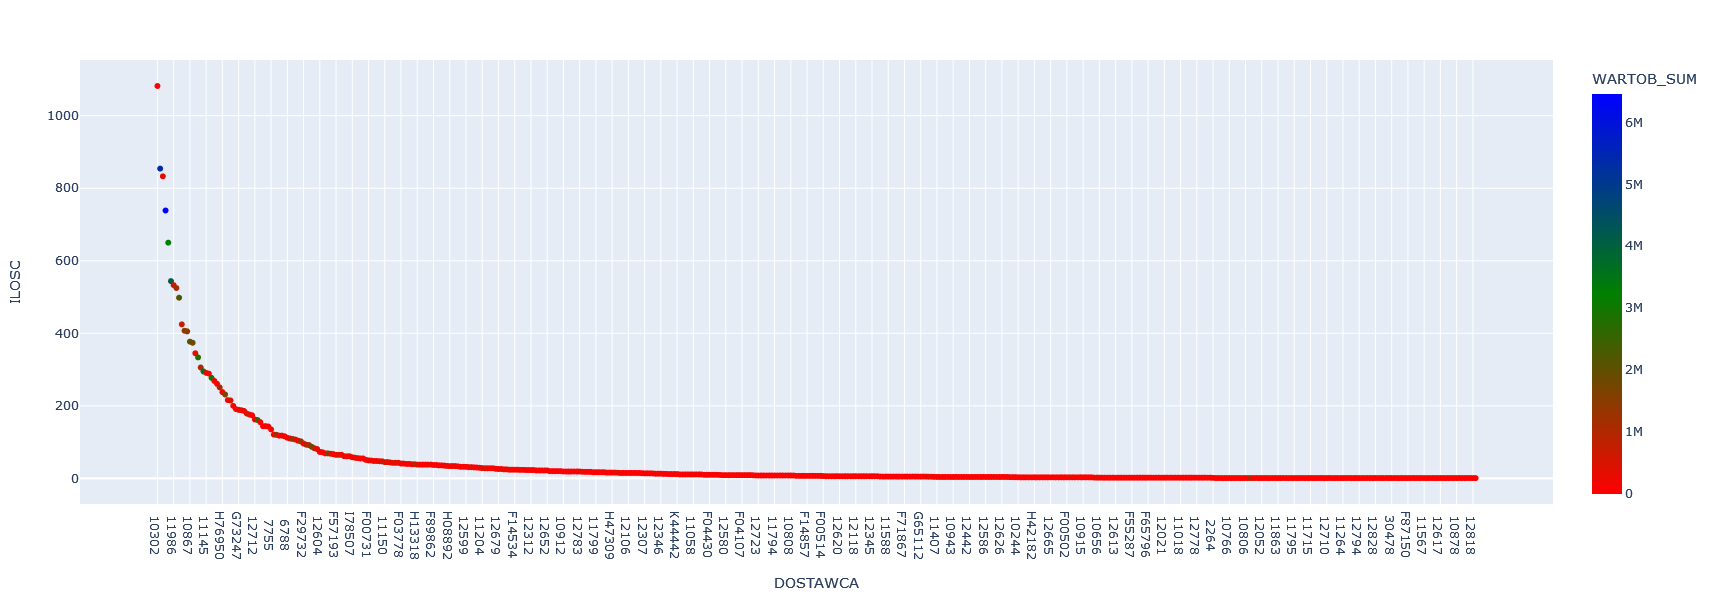

In [68]:
func_plot_scatter(df_fi, {'ILOSC':'sum',
                         'CENA_POZYCJA':'sum'},
                  'DOSTAWCA',
                 df_sell)

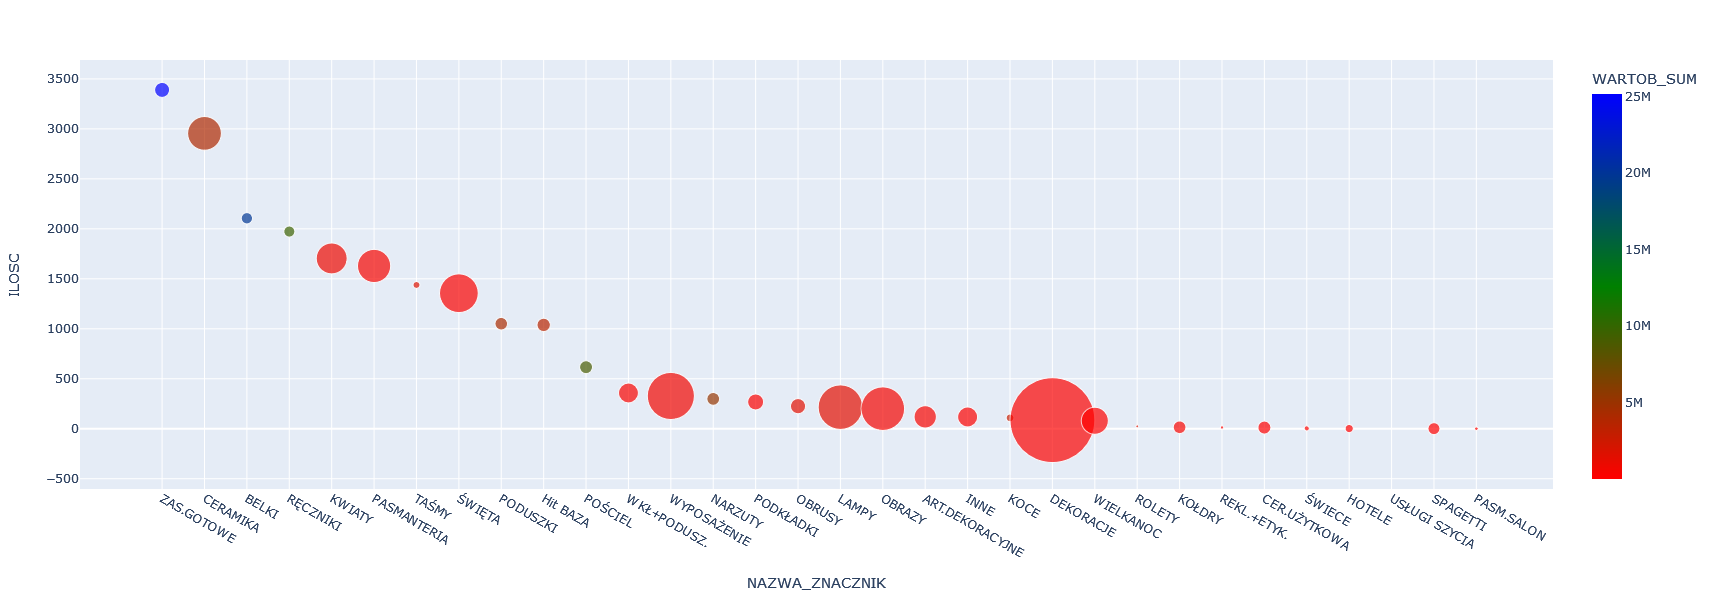

In [69]:
func_plot_scatter(df_fi, {'ILOSC':'sum',
                         'CENA_POZYCJA':'sum'}, 
                  'NAZWA_ZNACZNIK',
                 df_sell)

In [70]:
len(df_fi)

61105

In [37]:
if 'sprzedaz_calego_dostawcy' in df_fi:
    pass
else:
    df_fi=df_fi.merge(df_sell.loc[df_sell['ILOSC_SUM']>0].groupby('DOSTAWCA').agg(sprzedaz_calego_dostawcy=('WARTOB_SUM','sum'),
                                                     sprzedaz_calego_dostawcy_ilosc=('ILOSC_SUM','sum')).reset_index(), how='left', on=['DOSTAWCA'])
    df_fi=df_fi.merge(df_sell.loc[df_sell['ILOSC_SUM']>0].groupby(['DOSTAWCA','NAZWA_ZNACZNIK']).agg(sprzedaz_znacznik_dostawcy=('WARTOB_SUM','sum'),
                                                     sprzedaz_znacznik_dostawcy_ilosc=('ILOSC_SUM','sum')).reset_index(), how='left', on=['DOSTAWCA','NAZWA_ZNACZNIK'])
    df_fi=df_fi.merge(df_sell.loc[df_sell['ILOSC_SUM']>0].groupby(['DOSTAWCA','KOD_TEMA']).agg(sprzedaz_kod_tema_dostawcy=('WARTOB_SUM','sum'),
                                                     sprzedaz_kod_tema_dostawcy_ilosc=('ILOSC_SUM','sum')).reset_index(), how='left', on=['DOSTAWCA','KOD_TEMA'])

In [38]:
df_fi=df_fi.fillna(0)

In [40]:
df_fi_sell=df_fi.loc[df_fi['ANALIT01'].isin(['LI','FE', 'OU'])].\
    groupby(['ANALIT02','DOSTAWCA','NAZWA_ZNACZNIK','RODZAJ','KOD_TEMA']).agg({'ILOSC':'sum',
                                                                               'CENA_POZYCJA':'sum',
                                                                               'Z_DNIA':'nunique',
                                                                               'sprzedaz_calego_dostawcy_ilosc':'first',
                                                                      'sprzedaz_znacznik_dostawcy_ilosc':'first',
                                                                      #'sprzedaz_kod_tema_dostawcy_ilosc':'first',
                                                                     'sprzedaz_calego_dostawcy':'first',
                                                                      'sprzedaz_znacznik_dostawcy':'first'}).reset_index().\
        groupby(['ANALIT02','DOSTAWCA','NAZWA_ZNACZNIK']).agg({'ILOSC':'sum',
                                                                               'CENA_POZYCJA':'sum',
                                                                               'Z_DNIA':'sum',
                                                                               'sprzedaz_calego_dostawcy_ilosc':'first',
                                                                      'sprzedaz_znacznik_dostawcy_ilosc':'first',
                                                                      #'sprzedaz_kod_tema_dostawcy_ilosc':'first',
                                                                     'sprzedaz_calego_dostawcy':'first',
                                                                      'sprzedaz_znacznik_dostawcy':'first'}).reset_index()

# df_fi_sell=df_fi_sell.merge(df_fi.loc[df_fi['ANALIT01'].isin(['LI','FE', 'OU'])].\
#                                 groupby(['FAKTURA','ANALIT02','DOSTAWCA','NAZWA_ZNACZNIK']).agg({'WARTOSC_B':'first'}).reset_index().\
#                                 groupby(['ANALIT02','DOSTAWCA','NAZWA_ZNACZNIK']).agg({'WARTOSC_B':'sum'}).reset_index(),
#                             how='left',
#                             on=['ANALIT02','DOSTAWCA','NAZWA_ZNACZNIK'])

In [21]:
len(df_fi_sell.loc[df_fi_sell['ILOSC']>df_fi_sell['sprzedaz_znacznik_dostawcy_ilosc']])

28

In [22]:
len(df_fi_sell)

1144

In [44]:
from sklearn.cluster import KMeans

In [45]:
from sklearn.metrics import silhouette_score
def func_choose_k(x):
    sil = []
    kmax = 6
    for k in range(2, kmax+1):
        kmeans = KMeans(n_clusters = k).fit(x)
        labels = kmeans.labels_
        sil.append(silhouette_score(x, labels, metric = 'euclidean'))
    plt.plot(range(2, kmax+1), sil)
    plt.show()

    
def func_odwroc_pred(x, x_centers):
    if x_centers[0][1]>x_centers[1][1]:
        return x
    else:
        for i in range(0,len(x)):
            if x[i]==0:
                x[i]=1
            else:
                x[i]=0
        return x
    
    
def func_cluster(df, znacznik, gdzie, plot=1):
    if znacznik!='':
        df=df.loc[df['NAZWA_ZNACZNIK']==znacznik]
        df=df.loc[df['ANALIT02']==gdzie]
        df=df.loc[df['ILOSC']<=df['sprzedaz_calego_dostawcy_ilosc']]
        df['proc_reklamacji_do_znacznik_dostawca']=df['ILOSC']/df['sprzedaz_znacznik_dostawcy_ilosc']*100
        #display(df.sort_values(by='proc_reklamacji_do_znacznik_dostawca'))
        try:
            kmeans = KMeans(n_clusters=2, random_state=0).fit(df[['ILOSC','proc_reklamacji_do_znacznik_dostawca']])
            x_pred=kmeans.predict(df[['ILOSC','proc_reklamacji_do_znacznik_dostawca']])
            #print(kmeans.labels_, kmeans.cluster_centers_)
            x_pred=func_odwroc_pred(x_pred, kmeans.cluster_centers_)
            df['pred_cluster']=x_pred
            df['pred_cluster']=df['pred_cluster'].astype(str)
            if plot:
                fig=px.scatter(df,
                               x='ILOSC',
                               color='CENA_POZYCJA',
                               y='proc_reklamacji_do_znacznik_dostawca',
                              color_continuous_scale=["red", "green", "blue"])#px.colors.sequential.solar_r)
                fig.show()
                func_choose_k(df[['ILOSC','proc_reklamacji_do_znacznik_dostawca']])
                
            return df[['NAZWA_ZNACZNIK','ANALIT02', 'DOSTAWCA', 'pred_cluster']]
        except: return
    
    
    else:
        df=df.groupby(['ANALIT02','DOSTAWCA']).agg({'CENA_POZYCJA':'sum',
                                                    'ILOSC':'sum',
                                                       'Z_DNIA':'sum',
                                                       'sprzedaz_calego_dostawcy_ilosc':'first',
                                             'sprzedaz_calego_dostawcy':'first'}).reset_index()
        df=df.loc[df['ILOSC']<=df['sprzedaz_calego_dostawcy_ilosc']]
        df=df.loc[df['ANALIT02']==gdzie]
        df['proc_reklamacji_do_dostawca']=df['ILOSC']/df['sprzedaz_calego_dostawcy_ilosc']*100
        #display(df.corr())
        
        kmeans = KMeans(n_clusters=2, random_state=0).fit(df[['ILOSC','proc_reklamacji_do_dostawca']])
        x_pred=kmeans.predict(df[['ILOSC','proc_reklamacji_do_dostawca']])
        df['pred_cluster']=x_pred
        df['pred_cluster']=df['pred_cluster'].astype(str)
        if plot:
            fig=px.scatter(df,
                           x='ILOSC',
                           color='CENA_POZYCJA',
                           #symbol='ANALIT02',
                           y='proc_reklamacji_do_dostawca',
                              color_continuous_scale=["red", "green", "blue"])
            fig.show()
        func_choose_k(df[['ILOSC','proc_reklamacji_do_dostawca']])
#         x_min, x_max = df['ILOSC'].min(),df['ILOSC'].max()
#         y_min, y_max = df['proc_reklamacji_do_dostawca'].min(),df['proc_reklamacji_do_dostawca'].max()
#         xx, yy = np.meshgrid(np.arange(x_min, x_max, 1), np.arange(y_min, y_max, 1))

#         # Obtain labels for each point in mesh. Use last trained model.
#         Z = kmeans.predict(np.c_[xx.ravel(), yy.ravel()])

#         # Put the result into a color plot
#         Z = Z.reshape(xx.shape)
#         plt.clf()
#         plt.imshow(
#             Z,
#             interpolation="nearest",
#             extent=(xx.min(), xx.max(), yy.min(), yy.max()),
#             cmap=plt.cm.Paired,
#             aspect="auto",
#             origin="lower",
#         )
#         plt.scatter(x=df['ILOSC'],
#                    y=df['proc_reklamacji_do_dostawca'])
#         plt.scatter(x=kmeans.cluster_centers_[:,0],
#                     y=kmeans.cluster_centers_[:,1],
#                    color='green')
#         plt.show()

In [382]:
_=pd.DataFrame()
for i in df_fi_sell['NAZWA_ZNACZNIK'].unique():
    _=_.append(func_cluster(df_fi_sell, i, 'OUTLET', None))
    #break

In [356]:
_.pivot(index='DOSTAWCA',
       columns='NAZWA_ZNACZNIK',
       values='pred_cluster').to_excel(path_to_catalog+'usun_pivot_outlet.xlsx')

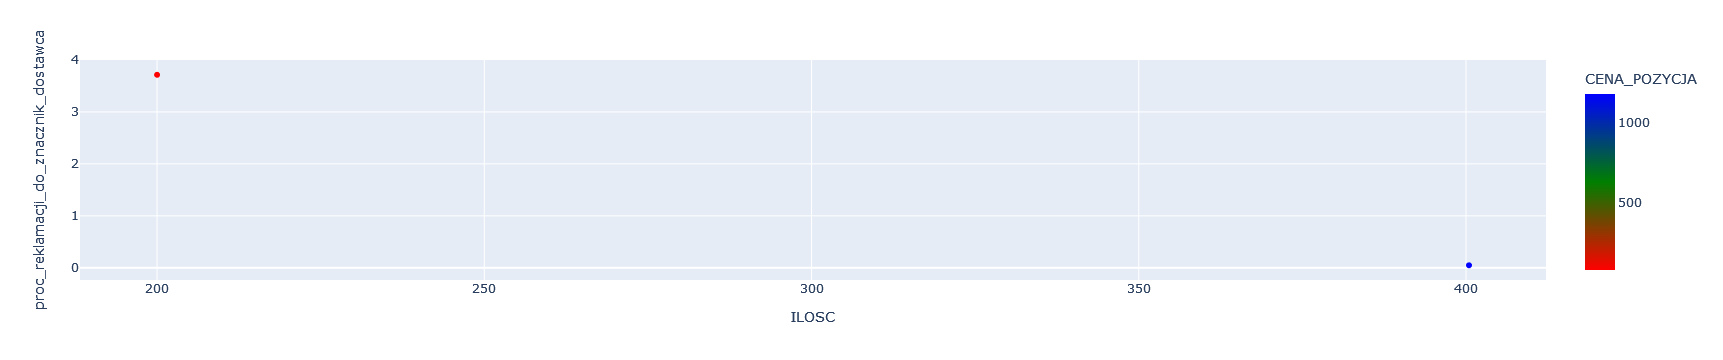

In [26]:
func_cluster(df_fi_sell, 'TAŚMY', 'OUTLET')

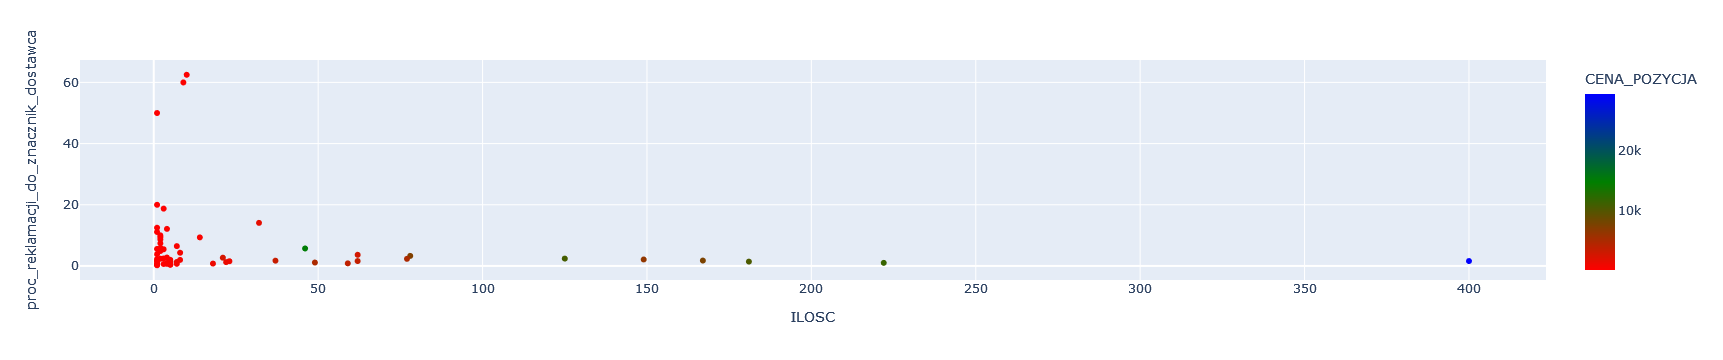

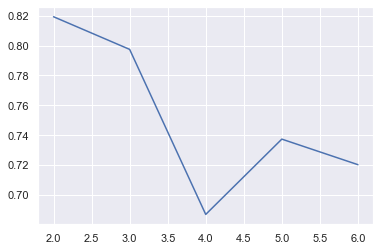

,NAZWA_ZNACZNIK,ANALIT02,DOSTAWCA,pred_cluster
312,CERAMIKA,LIKWIDACJA,,0
322,CERAMIKA,LIKWIDACJA,6788,0
355,CERAMIKA,LIKWIDACJA,10863,0
359,CERAMIKA,LIKWIDACJA,10872,0
360,CERAMIKA,LIKWIDACJA,10875,0
...,...,...,...,...
620,CERAMIKA,LIKWIDACJA,H76950,0
622,CERAMIKA,LIKWIDACJA,I16019,0
629,CERAMIKA,LIKWIDACJA,J24700,1
630,CERAMIKA,LIKWIDACJA,J25206,0


In [46]:
func_cluster(df_fi_sell, 'CERAMIKA', 'LIKWIDACJA', 1)

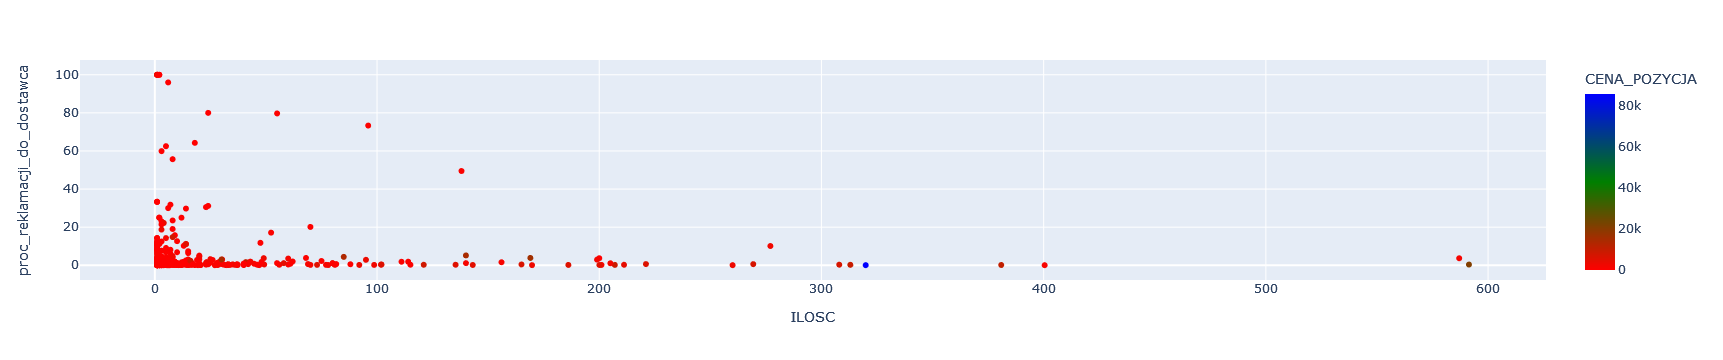

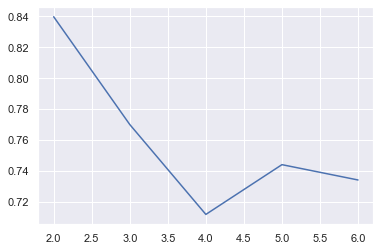

In [28]:
func_cluster(df_fi_sell, '', 'OUTLET',1)

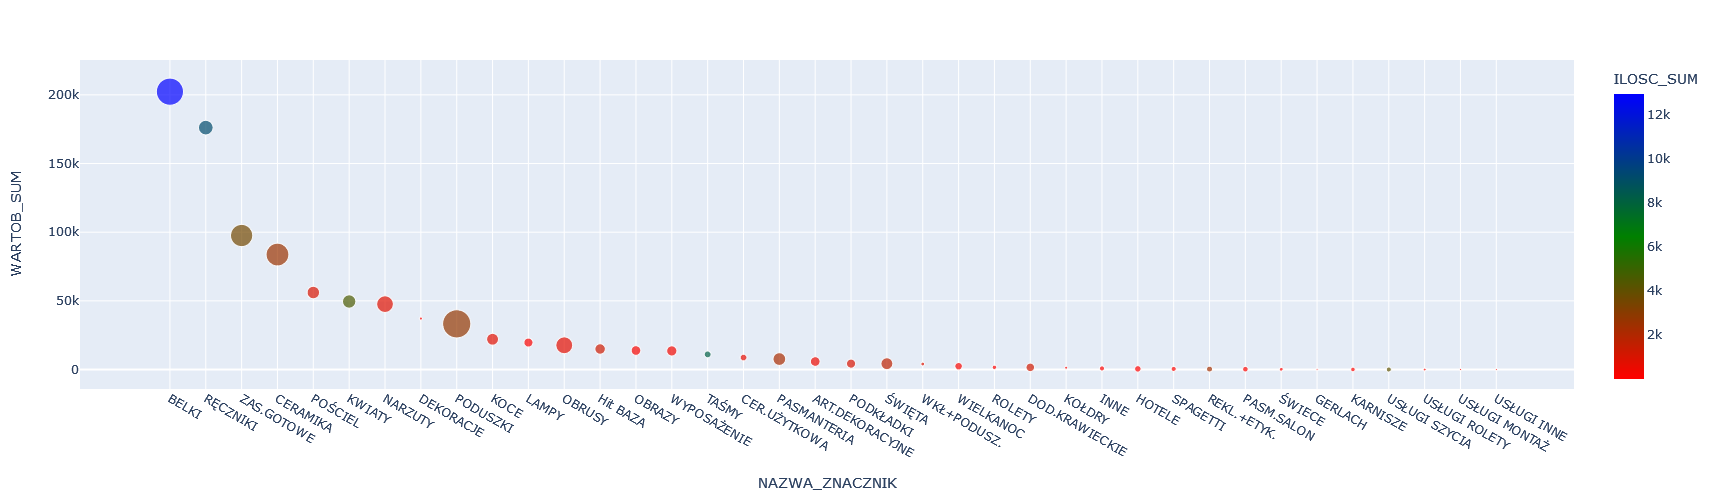

In [106]:
px.scatter(df_sell.loc[df_sell['ANALIT01']=='OU'].groupby(['NAZWA_ZNACZNIK']).agg({'WARTOB_SUM':'sum',
                                                                                  'ILOSC_SUM':'sum',
                                                                                  'TRZY':'nunique'}).reset_index().sort_values(by='WARTOB_SUM', ascending=False),
           x='NAZWA_ZNACZNIK',
           y='WARTOB_SUM',
           color='ILOSC_SUM',
          color_continuous_scale=['red', 'green','blue'],
          size='TRZY',
          height=500)

In [93]:
df_sell.groupby('ANALIT01').agg({'WARTOB_SUM':'sum'}).sort_values(by='WARTOB_SUM', ascending=False)

,WARTOB_SUM
ANALIT01,
00,5.330691e+07
SI,1.207249e+07
,9.910097e+06
FR,8.717820e+06
SW,8.671142e+06
SF,2.685968e+06
OU,9.427402e+05
FE,4.100300e+02


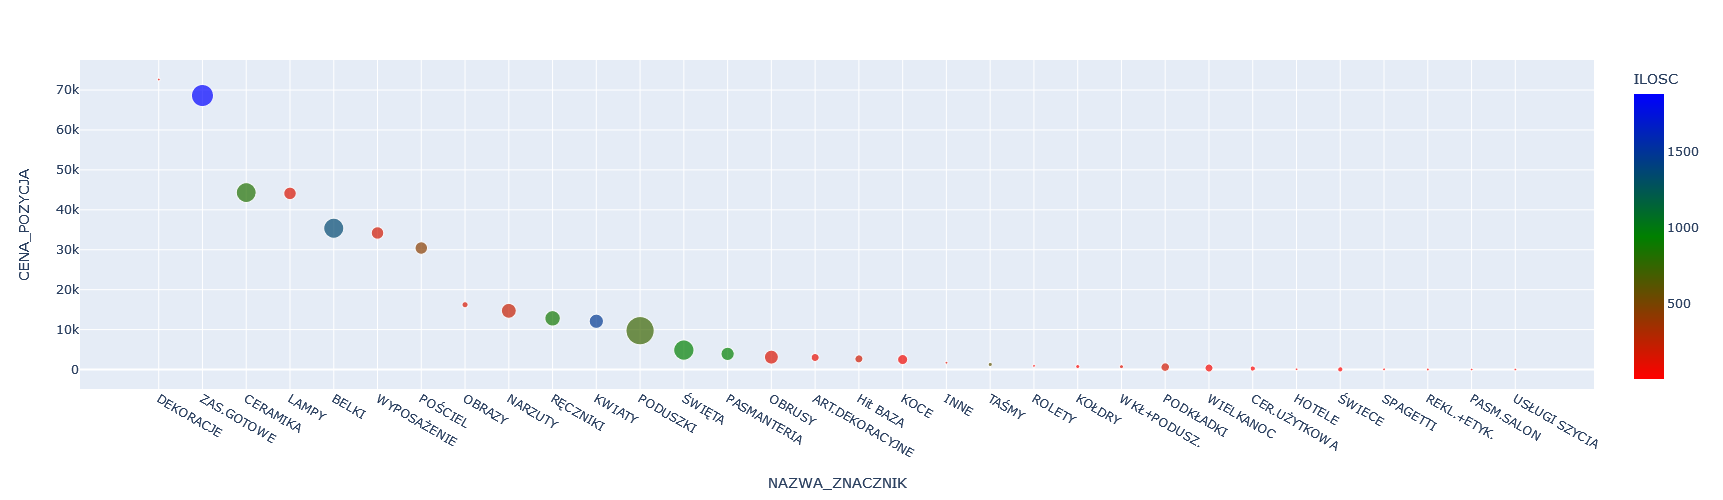

In [110]:
px.scatter(df_fi.loc[df_fi['ANALIT01']=='OU'].groupby(['NAZWA_ZNACZNIK']).agg({'CENA_POZYCJA':'sum',
                                                                                  'ILOSC':'sum',
                                                                                  'TRZY':'nunique'}).reset_index().sort_values(by='CENA_POZYCJA', ascending=False),
           x='NAZWA_ZNACZNIK',
           y='CENA_POZYCJA',
           color='ILOSC',
          color_continuous_scale=['red', 'green','blue'],
          size='TRZY',
          height=500)

In [111]:
df_fi.loc[df_fi['ANALIT01']=='OU'].groupby(['NAZWA_ZNACZNIK']).agg({'CENA_POZYCJA':'sum',
                                                                                  'ILOSC':'sum',
                                                                                  'TRZY':'nunique'}).reset_index().sort_values(by='CENA_POZYCJA', ascending=False).\
merge(df_sell.loc[df_sell['ANALIT01']=='OU'].groupby(['NAZWA_ZNACZNIK']).agg({'WARTOB_SUM':'sum',
                                                                                  'ILOSC_SUM':'sum',
                                                                                  'TRZY':'nunique'}).reset_index().sort_values(by='WARTOB_SUM', ascending=False),
how='outer',
on='NAZWA_ZNACZNIK')

,NAZWA_ZNACZNIK,CENA_POZYCJA,ILOSC,TRZY_x,WARTOB_SUM,ILOSC_SUM,TRZY_y
0,DEKORACJE,72649.383093,75.41,1.0,37148.62,42.000000,2
1,ZAS.GOTOWE,68623.581900,1885.00,52.0,97579.46,3569.650000,93
2,CERAMIKA,44314.366200,826.00,42.0,83695.54,2538.000000,98
3,LAMPY,44109.189900,138.00,17.0,19635.24,123.000000,16
4,BELKI,35380.904613,1356.51,43.0,202318.45,12920.991566,139
5,WYPOSAŻENIE,34194.922500,172.00,17.0,13546.70,340.000000,20
6,POŚCIEL,30425.169300,440.00,17.0,56063.72,973.000000,30
7,OBRAZY,16221.904200,148.00,4.0,13856.35,184.000000,18
8,NARZUTY,14699.701200,217.00,24.0,47618.77,811.000000,53
9,RĘCZNIKI,12810.548400,879.00,26.0,176142.85,9197.000000,41


In [107]:
df_fi.columns

Index(['FAKTURA', 'FAKTURA_FK', 'Z_DNIA', 'WARTOSC_B', 'KOD', 'OPIS', 'NAZWA',
       'RODZAJ', 'KOD_TEMA', 'ILOSC', 'CENA_POZYCJA', 'FAKTURA_NUMER',
       'ZNACZNIK', 'DOSTAWCA', 'TRZY', 'NAZWA_ZNACZNIK', 'year', 'month',
       'day_of_year', 'week', 'week_day', 'year_month', 'year_week',
       'year_day', 'ANALIT01', 'ANALIT02'],
      dtype='object')

In [71]:
_=pd.read_csv('../słowniki/slownik.csv',
           encoding='Cp1250',
              sep="|")#.columns

In [77]:
_.loc[_['DOSTAWCA']==' 10302']#.iloc[:1]

,RECNO,IS_DELETED,NAZWA,RODZAJ,KOD_TEMA,KOD_TEMA_W,KOD_TEMA_K,FUN_KW,ZNACZNIK,NR_ZAKL_P,CENA_Z,PCENA_Z,CENA,CENA_D,GRUPA,PODGRUPA,VAT_P,VAT_R,VAT_N,SWW,PKWIU,OST_PRZ,OST_FAKT,MIN_ZAM,IL_MIN,IL_MAX,DZIENNY_R,DZIENNY_RC,W_ZGRZEWCE,SZTUK_KART,W_WARSTWIE,W_PALECIE,SUMA_DNI,ILOSC,ZALECAM,ILOSC_MAG,DATA_PRZY,DOSTAWCA,KOD_PASEK,ILOSC_II,JM,LOKACJA,KOD_HS,ILMAX_LOKW,CENA_F,CENA_P,CENA_S,WSPC_H,WSPC_D,WSPC_S,WSPC_P,DATA_PROM,ILOSC_PROM,DATA_WPISU,DATA_ARCH,OPER_ARCH,TYP_TOWARU,OPIS,ATEST,RODZ_PAKOW,BLOK_SPRZ,BLOK_ODDZ,KATEGORIA,POZYC_W_GR,DNI_WAZN,GRAMATURA,WAGA_BRUT,WAGA_ODC,SZER_KART,DLG_KART,WYS_KART,WYS_WARSTW,BLOK_MARZ,BL_ZM_AKT,PODZ_LUZ,ZAOK_ZAMD,KOD_PROMOC,TYP_TOW2,STATUS_I,DATA_KAT,TYP_FILI,LITRAZ,BL_ZM_CSP,AKTYWNOSC,ZAM_DOST,CENA_X,CENA_X2,CENA_X3,CENA_X4,ID_POZ_KOL,TOW_JEDNOR,CENA_WAL,CENA_WAL2,KOD_PRODUC,TYP_OPAK,RODZ_OPAK,KOD_PCN,KOD_KR,CLO,OPIS_TOW,NAZWA_INT,OPIS_INT,TOP10,TOP10D,KOLEJN_INT,CECH_INT01,CECH_INT02,CECH_INT03,CECH_INT04,CECH_INT05,CECH_INT06,KONTO_P,DOP_ODCHKG,CECH01,CECH02,CECH03,CECH04,CECH05,CECH06,CECH07,CECH08,CECH09,CECH10,KOLEKCJA,ROZMIAR,KOD_KOLOR,TOW_KURCZ,TOW_WZOR,TOW_RAPORT,GRAM_MATER,PROBNIK,SYMBOL_IMP,NAZWA_IMP,SKLAD_TOW,KANAL_DYST,PARAM_TECH,P_WYDR_ZUZ,ROZR_LOKAC,IE$0,IE$1,IE$2,IE$3,IE$4,IE$5,IE$6,IE$7,NAZWANAFAK,REKL_TOW,DATA_1PRZ,DATA_1PRZS,DATA_1PRZA,DATA_1PRZB,NR_CENNCZ,KOR_WYMIAR,NAZWA_KAT,MIN_PPAL,KOD_METKI,NR_ET_PRAN,MIN_UPUST,MAX_UPUST,NADZOR,NAZWA_M,RODZAJ_M,NAZWA_IN,RODZAJ_IN,SRCENA_Z,CECHPWZ,DNI_WAZN_S,DNI_WAZN_P,KOD_KUPCA,KOD_ZAOPAT,MARKA_PROD,PODPOWIADA,MM_SF,TYP_ROZM,SEZON,WZOR,CENA_AKCYZ,PLAN_CEZAR,KOD_KRES,STAN_KODPL,W_OPAK,GRAM_GSM,POZYC_W_ZN,IL_UZUP_JM,CZY_MPP,BLOK_MODUL,KOD_GTU,KOD_CN,KOD_PROC,TRZY,CENA_11,CENA_12,CENA_13,CENA_14,CENA_15,GRAM_CUK,GRAM_KOF,GRAM_TAU,GRAM_GUA,OPLAT_CUK,OPLAT_ALK,REALOK_BW,ZALEC_LUZ,SUBST_SLO,UD_SOK_OW,ROZTW_WE,WAG_N_PAK,TEMP_MIN,TEMP_MAX,DR_DOD_OPT,PMARKA_PRO,PLINIA_PRO,KOD_BLOZ,ZALACZNIK,DATA_VAT_N,KNTR_DWAZN
211,271,N,SC/203,,30328,0,0,,12,0,"5,54",0,"9,97","22,9",15,0401,23,23,0,,,0,,0,0,0,0,0,0,0,0,0,0,0,0,0,09/02/23,10302,,0,2,,,0,"10,97","22,9",0,0,0,0,0,12/01/01,0,12/01/01,12/01/01,0,,0,,,0,,,0,0,500,550,0,0,0,0,0,0,,,,0,,,12/01/01,,0,,,,0,0,"14,7","2,1",,N,0,0,,,,5808900000,CN,0,,,,0,0,0,,,,,,,,0,,,,,T,,,,15,040,,,,,,,,,,,100% POLIESTER,,,,,SC/203,12SC/203,15SC/203,30328,SC/203,12SC/203,15SC/203,,,,09/02/23,12/01/01,12/01/01,12/01/01,,,UPINACZ DEKORACYJNY Z MAGNESEM,0,,,,,,,,,,0,,0,0,0,0,,,,,,,0,,,,0,0,0,0,,,,58089000,,23,"10,97",0,0,0,0,0,0,0,0,0,0,,,,,,0,0,0,,,,,,12/01/01,
685,89138,N,PC/1542/B,,126196,0,0,,12,0,"2,32",0,"4,3","9,9",15,0504,23,23,0,,,300,PZ0000000425,0,0,0,"4,3","4,3",0,50,0,0,0,0,0,0,17/03/15,10302,5900811642206,0,7,,,0,"4,94","9,9","4,3",0,0,0,0,12/01/01,0,12/01/01,12/01/01,0,,0,T,,0,,,0,0,500,550,0,0,0,0,0,0,,,,0,,,12/01/01,,0,,,,0,0,"6,3","0,9",,N,"0,5",0,,,,5407699000,CN,0,,,,0,0,0,,,,,,,,0,,,,,T,,,,15,050,,,001,,,,,,FYGI713005,WHITE,100% POLIESTER,,,,,PC/1542/B,12PC/1542/B,15PC/1542/B,126196,PC/1542/B,12PC/1542/B,15PC/1542/B,5900811642206,,,17/03/15,12/01/01,12/01/01,12/01/01,,,OBSZYWKA DEKORACYJNA,0,,,,,,,,,,"2,32",,0,0,0,0,,,,,,,0,,,,0,0,0,0,,,,54076990,,23,"4,73",0,0,0,0,0,0,0,0,0,0,,,,,,0,0,0,,,,,,12/01/01,
4829,7475,N,F/SC/6/1085/MIOD,FYTA 251077C-2,20080,0,0,,12,0,"9,08",0,"20,11","44,9",15,0315,23,23,0,,,0,,0,0,0,"20,11","20,11",0,0,0,0,0,0,0,0,12/01/01,10302,5900811724834,0,2,,,0,"22,12","44,9","20,11",0,0,0,0,12/01/01,0,12/01/01,12/01/01,0,,0,,,0,,,0,0,500,550,0,0,0,0,0,0,,,,0,,,12/01/01,,0,,,,0,0,"29,7","4,23",,N,0,0,,,,5808900000,CN,0,,,,0,0,0,,,,,,,,0,,,N,,,,,,0,,,,,,,,,,,,100% POLIESTER,,,,,F/SC/6/1085/MIODFYTA 251077C-2,12F/SC/6/1085/MIODFYTA 251077C-2,15F/SC/6/1085/MIODFYTA 251077C-2,20080,F/SC/6/1085/MIODFYTA 251077C-2,12F/SC/6/1085/MIODFYTA 251077C-2,15F/SC/6/1085/MIODFYTA 251077C-2,5900811724834,,,12/01/01,12/01/01,12/01/01,12/01/01,,,,0,,,,,,,,,,0,,0,0,0,0,,,,,,,0,,,,0,0,0,0,,,,58089000,,23,"22,12",0,0,0,0,0,0,0,0,0,0,,,,,,0,0,0,,,,,,12/01/01,
5556,7019,N,F/D.PLASTIC/B,KOŁO,83243,0,0,,12,0,"2,53

In [404]:
df_fi.loc[df_fi['ANALIT01'].isin(['LI','FE', 'OU'])].groupby(['ANALIT01','FAKTURA']).agg({'WARTOSC_B':'first'}).reset_index().\
                                                        groupby(['ANALIT01']).agg({'WARTOSC_B':'sum',
                                                                                  'FAKTURA':'nunique'})

,WARTOSC_B,FAKTURA
ANALIT01,,
FE,210587.19,674
LI,261213.17,2120
OU,466766.84,3517


In [400]:
df_fi.loc[df_fi['ANALIT01'].isin(['LI','FE', 'OU'])].groupby(['ANALIT01']).agg({'FAKTURA':'nunique'})

,FAKTURA
ANALIT01,
FE,674
LI,2120
OU,3517


In [402]:
df_fi.loc[df_fi['ANALIT01'].isin(['LI','FE', 'OU'])]['FAKTURA'].nunique()

6311

In [421]:
df_fi

,FAKTURA,FAKTURA_FK,Z_DNIA,WARTOSC_B,KOD,OPIS,NAZWA,RODZAJ,KOD_TEMA,ILOSC,FAKTURA_NUMER,ZNACZNIK,DOSTAWCA,NAZWA_ZNACZNIK,year,month,day_of_year,week,week_day,year_month,year_week,year_day,ANALIT01,ANALIT02,sprzedaz_calego_dostawcy,sprzedaz_calego_dostawcy_ilosc,sprzedaz_znacznik_dostawcy,sprzedaz_znacznik_dostawcy_ilosc,sprzedaz_kod_tema_dostawcy,sprzedaz_kod_tema_dostawcy_ilosc
0,MM5600129162,,2022-01-28,86.22,LI,44,ZAS/SPECIAL/B,140X250 78,204218,2.0,00129162,3.0,10677,ZAS.GOTOWE,2022,1,28,4,5,2022-01-01,2022--04,2022--028,LI,LIKWIDACJA,2.921993e+04,1492.902778,1.469002e+04,399.000000,0.000000,0.0
1,MM5600129163,,2022-01-28,229.35,LI,44,ZAS/ELIE/B+RÓŻ,140X250 PRZEL,364657,1.0,00129163,3.0,F55032,ZAS.GOTOWE,2022,1,28,4,5,2022-01-01,2022--04,2022--028,LI,LIKWIDACJA,4.683334e+06,132798.307692,4.552218e+06,120570.307692,19979.050000,458.0
2,MM5600129163,,2022-01-28,229.35,LI,44,FIR/ESIM/B,140X250 PRZEL,333886,1.0,00129163,3.0,11447,ZAS.GOTOWE,2022,1,28,4,5,2022-01-01,2022--04,2022--028,LI,LIKWIDACJA,5.858700e+06,148951.900000,5.509876e+06,126138.250000,41606.936328,1700.0
3,MM5600129163,,2022-01-28,229.35,LI,44,ZAS/MARIAH/K+MU,140X250 PRZEL,371969,1.0,00129163,3.0,12459,ZAS.GOTOWE,2022,1,28,4,5,2022-01-01,2022--04,2022--028,LI,LIKWIDACJA,3.201503e+06,93504.380000,2.753323e+06,72535.000000,25923.760000,595.0
4,MM5600129163,,2022-01-28,229.35,LI,44,FIR/SEYLAN/B+SRE,140X250 PRZEL,326708,1.0,00129163,3.0,F55032,ZAS.GOTOWE,2022,1,28,4,5,2022-01-01,2022--04,2022--028,LI,LIKWIDACJA,4.683334e+06,132798.307692,4.552218e+06,120570.307692,9552.220000,310.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67128,MM5600149969,,2022-07-19,1986.19,00,11,PIER/ZAS/SIBEL,140X270 T K,378076,2.0,00149969,3.0,H00846,ZAS.GOTOWE,2022,7,200,29,2,2022-07-01,2022--29,2022--200,00,MAGAZYN_00,7.030572e+06,226057.713131,6.389317e+06,176241.000000,37792.420000,759.0
67129,MM5600149969,,2022-07-19,1986.19,00,11,ZAS/DAVOS/B+ZIE,140X250 PRZEL,373048,5.0,00149969,3.0,H00846,ZAS.GOTOWE,2022,7,200,29,2,2022-07-01,2022--29,2022--200,00,MAGAZYN_00,7.030572e+06,226057.713131,6.389317e+06,176241.000000,280526.160000,5177.0
67130,MM5600149969,,2022-07-19,1986.19,00,11,ZAS/MELANIE/GRAF,140X250 PRZEL,373407,5.0,00149969,3.0,H00846,ZAS.GOTOWE,2022,7,200,29,2,2022-07-01,2022--29,2022--200,00,MAGAZYN_00,7.030572e+06,226057.713131,6.389317e+06,176241.000000,46331.900000,1301.0
67131,MM5600149969,,2022-07-19,1986.19,00,11,D91/Z/POLI/CZ+ZŁ,140X250 PRZEL,372581,1.0,00149969,3.0,F55032,ZAS.GOTOWE,2022,7,200,29,2,2022-07-01,2022--29,2022--200,00,MAGAZYN_00,4.683334e+06,132798.307692,4.552218e+06,120570.307692,61.780000,2.0


In [420]:
df_szac_bez_duplikatow=pd.DataFrame()
brak_zmiany_ceny=0
zmiana_ceny=0
ind_zmiana_ceny=[]
for fakt in tqdm(df_szac['FAKTURA'].unique()):
    for nazwa in df_szac.loc[df_szac['FAKTURA']==fakt]['NAZWA1_BEZ_F'].unique():
        if len(df_szac.loc[df_szac['FAKTURA']==fakt].loc[df_szac['NAZWA1_BEZ_F']==nazwa])>1:
            ind=df_szac.loc[df_szac['FAKTURA']==fakt].loc[df_szac['NAZWA1_BEZ_F']==nazwa].index
            if df_szac.loc[ind[0], 'CENA_Z1']!=df_szac.loc[ind[1], 'CENA_Z2']:
                zmiana_ceny+=1
                ind_zmiana_ceny=np.append(ind_zmiana_ceny, ind)
            else: brak_zmiany_ceny+=1
        else: continue


100%|██████████████████████████████████████████████████████████████████████████████| 4134/4134 [00:45<00:00, 91.49it/s]


In [411]:
brak_zmiany_ceny

4399

In [414]:
zmiana_ceny

174

In [419]:
df_szac.loc[df_szac['CENA_Z1']!=df_szac['CENA_Z2']]

,FAKTURA,FK,Z_DNIA,OPIS,TYP_PRZESZ,UZASADNIEN,NAZWA1,NAZWA2,RODZAJ1,RODZAJ2,KOD_TEMA,ILOSC1,ILOSC2,CENA_Z1,CENA_Z2,FAKTURA_NUMER,ZNACZNIK,DOSTAWCA,NAZWA_ZNACZNIK,year,month,day_of_year,week,week_day,year_month,year_week,year_day,NAZWA1_BEZ_F


In [417]:
df_szac.loc[ind_zmiana_ceny].head(50)

,FAKTURA,FK,Z_DNIA,OPIS,TYP_PRZESZ,UZASADNIEN,NAZWA1,NAZWA2,RODZAJ1,RODZAJ2,KOD_TEMA,ILOSC1,ILOSC2,CENA_Z1,CENA_Z2,FAKTURA_NUMER,ZNACZNIK,DOSTAWCA,NAZWA_ZNACZNIK,year,month,day_of_year,week,week_day,year_month,year_week,year_day,NAZWA1_BEZ_F
2193,SC5600034322,N,2022-02-01,Przecena towaru,8,Na podstawie korekty: ZF5600158928,SW/KW/SUZI1/CZER,SW/KW/SUZI1/CZER,18CM CZER+B,18CM CZER+B,221045,18,0,1.12,1.12,00034322,10.0,7755,ŚWIĘTA,2022,2,32,5,2,2022-02-01,2022--05,2022--032,SW/KW/SUZI1/CZER
2195,SC5600034322,N,2022-02-01,Przecena towaru,8,Na podstawie korekty: ZF5600158928,SW/KW/SUZI1/CZER,SW/KW/SUZI1/CZER,18CM CZER+B,18CM CZER+B,126521,37,0,2.83,2.83,00034322,10.0,12762,ŚWIĘTA,2022,2,32,5,2,2022-02-01,2022--05,2022--032,SW/KW/SUZI1/CZER
2194,SC5600034322,N,2022-02-01,Przecena towaru,8,Na podstawie korekty: ZF5600158928,F/SW/KW/SUZI1/CZ,F/SW/KW/SUZI1/CZ,18CM CZER+B,18CM CZER+B,320272,0,18,1.12,1.12,00034322,10.0,7755,ŚWIĘTA,2022,2,32,5,2,2022-02-01,2022--05,2022--032,SW/KW/SUZI1/CZ
2196,SC5600034322,N,2022-02-01,Przecena towaru,8,Na podstawie korekty: ZF5600158928,F/SW/KW/SUZI1/CZ,F/SW/KW/SUZI1/CZ,18CM CZER+B,18CM CZER+B,407341,0,37,2.83,2.83,00034322,10.0,12762,ŚWIĘTA,2022,2,32,5,2,2022-02-01,2022--05,2022--032,SW/KW/SUZI1/CZ
2199,SC5600034322,N,2022-02-01,Przecena towaru,8,Na podstawie korekty: ZF5600158928,SW/KW/WOLLY/CZER,SW/KW/WOLLY/CZER,18CM CZER,18CM CZER,221047,11,0,1.55,1.55,00034322,10.0,7755,ŚWIĘTA,2022,2,32,5,2,2022-02-01,2022--05,2022--032,SW/KW/WOLLY/CZER
2201,SC5600034322,N,2022-02-01,Przecena towaru,8,Na podstawie korekty: ZF5600158928,SW/KW/WOLLY/CZER,SW/KW/WOLLY/CZER,18CM CZER,18CM CZER,126525,25,0,4.50,4.50,00034322,10.0,12762,ŚWIĘTA,2022,2,32,5,2,2022-02-01,2022--05,2022--032,SW/KW/WOLLY/CZER
2200,SC5600034322,N,2022-02-01,Przecena towaru,8,Na podstawie korekty: ZF5600158928,F/SW/KW/WOLLY/CZ,F/SW/KW/WOLLY/CZ,18CM CZER,18CM CZER,310819,0,11,1.55,1.55,00034322,10.0,7755,ŚWIĘTA,2022,2,32,5,2,2022-02-01,2022--05,2022--032,SW/KW/WOLLY/CZ
2202,SC5600034322,N,2022-02-01,Przecena towaru,8,Na podstawie korekty: ZF5600158928,F/SW/KW/WOLLY/CZ,F/SW/KW/WOLLY/CZ,18CM CZER,18CM CZER,313626,0,25,4.50,4.50,00034322,10.0,12762,ŚWIĘTA,2022,2,32,5,2,2022-02-01,2022--05,2022--032,SW/KW/WOLLY/CZ
263,SC5600034236,T,2022-01-28,Zmiana stanu,0,,SW/B/STR/29A,SW/B/STR/29A,8CM SZAMP,8CM SZAMP,370433,1,0,3.64,3.64,00034236,10.0,11794,ŚWIĘTA,2022,1,28,4,5,2022-01-01,2022--04,2022--028,SW/B/STR/29A
264,SC5600034236,T,2022-01-28,Zmiana stanu,0,,SW/B/STR/29A,SW/B/STR/29A,8CM SZAMP,8CM SZAMP,370433,3,4,2.19,2.19,00034236,10.0,11794,ŚWIĘTA,2022,1,28,4,5,2022-01-01,2022--04,2022--028,SW/B/STR/29A


In [418]:
df_szac

,FAKTURA,FK,Z_DNIA,OPIS,TYP_PRZESZ,UZASADNIEN,NAZWA1,NAZWA2,RODZAJ1,RODZAJ2,KOD_TEMA,ILOSC1,ILOSC2,CENA_Z1,CENA_Z2,FAKTURA_NUMER,ZNACZNIK,DOSTAWCA,NAZWA_ZNACZNIK,year,month,day_of_year,week,week_day,year_month,year_week,year_day,NAZWA1_BEZ_F
0,SC5600034322,N,2022-02-01,Przecena towaru,8,Na podstawie korekty: ZF5600158928,F/SW/OZD/AMARO/0,F/SW/OZD/AMARO/0,20CM CZER KONIK,20CM CZER KONIK,313339,0,1,16.20,16.20,00034322,10.0,12420,ŚWIĘTA,2022,2,32,5,2,2022-02-01,2022--05,2022--032,SW/OZD/AMARO/0
1,SC5600034322,N,2022-02-01,Przecena towaru,8,Na podstawie korekty: ZF5600158928,SW/OZD/MAT/5,SW/OZD/MAT/5,19X22CM BORD,19X22CM BORD,348575,2,0,2.68,2.68,00034322,10.0,12604,ŚWIĘTA,2022,2,32,5,2,2022-02-01,2022--05,2022--032,SW/OZD/MAT/5
2,SC5600034322,N,2022-02-01,Przecena towaru,8,Na podstawie korekty: ZF5600158928,F/SW/OZD/MAT/5,F/SW/OZD/MAT/5,19X22CM BORD,19X22CM BORD,365980,0,2,2.68,2.68,00034322,10.0,12604,ŚWIĘTA,2022,2,32,5,2,2022-02-01,2022--05,2022--032,SW/OZD/MAT/5
3,SC5600034322,N,2022-02-01,Przecena towaru,8,Na podstawie korekty: ZF5600158928,SW/OZD/KENDAL/2,SW/OZD/KENDAL/2,15CM BORD,15CM BORD,320193,2,0,2.85,2.85,00034322,10.0,F29732,ŚWIĘTA,2022,2,32,5,2,2022-02-01,2022--05,2022--032,SW/OZD/KENDAL/2
4,SC5600034322,N,2022-02-01,Przecena towaru,8,Na podstawie korekty: ZF5600158928,F/SW/OZD/KENDAL/,F/SW/OZD/KENDAL/,15CM BORD,15CM BORD,407354,0,2,2.85,2.85,00034322,10.0,F29732,ŚWIĘTA,2022,2,32,5,2,2022-02-01,2022--05,2022--032,SW/OZD/KENDAL/
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13569,SC5600036594,N,2022-05-16,Przecena towaru,8,Na podstawie korekty: ZF5600176809,1070A/MARK/B,1070A/MARK/B,300,300,315750,"3,55",0,5.50,5.50,00036594,60.0,H19851,Hit BAZA,2022,5,136,20,1,2022-05-01,2022--20,2022--136,1070A/MARK/B
13570,SC5600036594,N,2022-05-16,Przecena towaru,8,Na podstawie korekty: ZF5600176809,F/1070A/MARK/B,F/1070A/MARK/B,300,300,327281,0,"3,55",5.50,5.50,00036594,1.0,H19851,BELKI,2022,5,136,20,1,2022-05-01,2022--20,2022--136,1070A/MARK/B
13571,SC5600036595,N,2022-05-16,Przecena towaru,8,Na podstawie korekty: ZF5600175222,FIR/LUCY/B,FIR/LUCY/B,140X250 PRZE,140X250 PRZE,224664,1,0,10.77,10.77,00036595,3.0,F05458,ZAS.GOTOWE,2022,5,136,20,1,2022-05-01,2022--20,2022--136,FIR/LUCY/B
13572,SC5600036595,N,2022-05-16,Przecena towaru,8,Na podstawie korekty: ZF5600175222,F/FIR/LUCY/B,F/FIR/LUCY/B,140X250 PRZE,140X250 PRZE,320766,0,1,10.77,10.77,00036595,3.0,F05458,ZAS.GOTOWE,2022,5,136,20,1,2022-05-01,2022--20,2022--136,FIR/LUCY/B


# inne

In [218]:
_s=pd.read_csv('../sprzedaz_fakty_bi/hurtbi_fakty_sprz_22.csv',encoding='Cp1250',
              sep="|")

In [142]:
_z=pd.read_csv('../słowniki/znacznik.csv',encoding='Cp1250',
              sep="|")[['ZNACZNIK','NAZWA']]

In [144]:
_z.loc[_z['ZNACZNIK']==91]

,ZNACZNIK,NAZWA
38,91,USŁUGI SZYCIA


In [203]:
_=pd.read_csv('../słowniki/slownik.csv',encoding='Cp1250',
              sep="|")#[['KOD_TEMA','ZNACZNIK','DOSTAWCA']]

In [145]:
_=_.merge(_z, how='left',on='ZNACZNIK')

In [140]:
np.sort(_['KOD_TEMA'].unique())

array([-10056, -10055, -10054, ..., 999997, 999998, 999999], dtype=int64)

In [147]:
_.loc[_['KOD_TEMA']<0]['NAZWA'].unique()

array(['INNE', 'USŁUGI SZYCIA', 'USŁUGI TRANSPORT', 'USŁUGI POS',
       'KARNISZE', 'USŁUGI INNE', 'USŁUGI ZAKUP', 'USŁUGI MONTAŻ',
       'USŁUGI ROLETY'], dtype=object)

In [149]:
pd.read_csv('../sprzedaz_fakty_bi/hurtbi_fakty_sprz_22.csv',encoding='Cp1250',
              sep="|")

,FAKTURA,DOKUMENT,Z_DNIA,FILIA,KOD_TEMA,TYP_DOK,JAK_POWST,WARTOB,ILOSC
0,FVM200002309,FM2A22/00002,22/01/03,M2,-10000.0,FV,K,0,0
1,FVM200002309,FM2A22/00002,22/01/03,M2,378079.0,FV,K,424,"10,6"
2,FVM200002309,FM2A22/00002,22/01/03,M2,378911.0,FV,K,340,"8,5"
3,FVM200002309,FM2A22/00002,22/01/03,M2,65080.0,FV,K,452,20
4,FVM200002309,FM2A22/00002,22/01/03,M2,50502.0,FV,K,44,200
...,...,...,...,...,...,...,...,...,...
536295,KV0000121311,KF0022/09742,22/03/28,0.0,3895.0,KV,ZI2O#,"-26,25",-1
536296,KV0000119927,KF0022/08378,22/03/16,0.0,387969.0,KV,Z,"-64,98",-1
536297,KV0000120112,KF0022/08563,22/03/17,0.0,62937.0,KV,ZI2O#,"-79,19","-5,6"
536298,KV0000117196,KF0022/05726,22/03/03,0.0,93844.0,KV,A,"-1,88",-1


In [88]:
import cx_Oracle

try:
    host = '192.168.0.206'
    port = 1521
    SID = 'orcl'
    
    dsn = cx_Oracle.makedsn(host, port, SID)
    
    connection = cx_Oracle.connect(user="EF_KG",
                                  password='',
                                  dsn=dsn,
                                   encoding="UTF-8")

    # show the version of the Oracle Database
    print(connection.version)
except cx_Oracle.Error as error:
    print(error)
finally:
    # release the connection
    if connection:
        connection.close()


DPI-1047: Cannot locate a 64-bit Oracle Client library: "The specified module could not be found". See https://cx-oracle.readthedocs.io/en/latest/user_guide/installation.html for help


NameError: name 'connection' is not defined